In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import os
from scipy import stats
from straxen import units
from scipy.ndimage import gaussian_filter1d

Start import
Working on midway2-0464.rcc.local with the following versions 
and installation paths:
strax
	v0.13.9	/dali/lgrandi/strax/strax/strax
straxen
	v0.15.8	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
dsets = st.select_runs(exclude_tags=('bad','messy'), run_mode='tpc_commissioning_kr*',
                       available=('event_info','peak_basics'))

Checking data availability: 100%|██████████| 3/3 [12:03<00:00, 241.32s/it]


In [4]:
dsets_1 = dsets[(dsets.end > pd.to_datetime('01/23/2021')) & (dsets.number<12245) & (dsets.livetime>np.timedelta64(30,'m'))]
run_1, nn_1 = np.array(dsets_1['name']), len(dsets_1)
dsets_2 = dsets[(dsets.number>=12245) & (dsets.number<=12443) & (dsets.livetime>np.timedelta64(30,'m'))]
run_2, nn_2 = np.array(dsets_2['name']), len(dsets_2)
print('Number of runs:\n',nn_1,'with liquid level at 4.8 mm\n',nn_2,'with liquid level at 5.5 mm')

Number of runs:
 40 with liquid level at 4.8 mm
 106 with liquid level at 5.5 mm


In [5]:
def plot_area_width_aft(events, run_id, low = 0, high = 6, low2 = 0, high2 = 1, binning = 500):
    ph_s1 = Histdd(events['s1_a_area'], events['s1_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_s2 = Histdd(events['s2_a_area'], events['s2_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    phcs1 = Histdd(events['s1_a_area'], events['s1_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    phcs2 = Histdd(events['s2_a_area'], events['s2_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    plt.figure(figsize=(12,6))
    ph_s1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    ph_s2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    plt.yscale('log')
    plt.figure(figsize=(12,6))
    phcs1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')

In [6]:
def mask_KrSingleS1(df):
    def line(x):
        return 0.55 * x + 15
    mask = (df['ds_s1_dt'] == 0)
    mask &= (df['s1_a_n_channels'] >= 90) & (df['s1_a_n_channels'] < 225)
    mask &= (line(df['s1_a_area']) > df['s1_a_n_channels'])
    mask &= (df['s1_a_range_50p_area'] >= 60) & (df['s1_a_range_50p_area'] < 1000)
    mask &= (df['s1_a_area_fraction_top'] < 0.68)
    return mask

In [7]:
def drift_velocity(events, run_id, low = 10, high = 3000, binning = 500, plot=False):
    if 'area_ratio' in events: pass
    else: events.insert(1, 'area_ratio', np.divide(events['cs2_a'],events['cs1_a']))
    events = events[events['area_ratio']<1e3]
    
    # cathode drop-off
    dt = np.linspace(low, high, binning)
    hdtime = Hist1d(events['drift_time']/1e3, bins=dt)
    hfilt = np.diff(gaussian_filter1d(hdtime,4))
    hmin = np.where(hfilt==hfilt.min())[0][0]
    cathodedt = dt[hmin]
    #cathodedt_err = dt[np.where(hdtime[hmin:]<1)[0][0]+hmin]-cathodedt
    if plot:
        plt.figure(figsize=(12,6))
        hdtime.plot(color='b',label='data')
        plt.ylabel("events", ha='right', y=1)
        plt.xlabel("drift time ($\mu$s)", ha='right', x=1)
        plt.axvline(x=cathodedt,linewidth=1,linestyle='-', color='r',label=f'$cathode = {cathodedt:.1f}~\mu$s')
        plt.legend(fontsize=14)

    mh = Histdd(events['drift_time']/1e3, events['area_ratio'],
            bins=(np.linspace(low, high, binning), np.logspace(0, 5, 200)))
    if plot:
        plt.figure(figsize=(12,6))
        mh.plot(log_scale=True, cblabel='events')
        plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
        plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
        plt.title(f'run {run_id}',fontsize=14)
        plt.yscale('log')
        plt.xlim(1500,high)
        plt.axvline(x=cathodedt,linewidth=1,linestyle='-', color='r',label=f'$cathode = {cathodedt:.1f}~\mu$s')
    
    # gate drift time
    dts = np.linspace(1, 20, 200)
    mh_low = Histdd(events['drift_time']/1e3, events['area_ratio'],
            bins=(dts, np.linspace(0, 200, 200)),axis_names=['drift_time', 'area_ratio'])
    median = mh_low.percentile(50, axis='area_ratio')
    mfilt = np.gradient(gaussian_filter1d(median, 4))
    gatedt = dts[np.where(mfilt==mfilt.min())[0][0]]
    vd = 1485/(cathodedt-gatedt)
    vd_err = vd*(10/cathodedt)
    if plot:
        plt.figure(figsize=(12,6))
        mh_low.plot(log_scale=False, cblabel='events')
        plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
        plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
        plt.title(f'run {run_id}',fontsize=14)
        median.plot(color='red',label='median')
        plt.axvline(x=gatedt,linewidth=1,linestyle='--', color='b',label=f'$gate = {gatedt:.1f}~\mu$s')
        plt.legend(fontsize=14)
        print(f'Drift velocity = {vd:.3f}~mm/$\mu$s')
    return vd, vd_err, cathodedt, gatedt

In [8]:
def drift_time_calculation( run_kr, plot = False ):
    run = int(run_kr)
    events = st.get_df(run_kr,'event_info_double',progress_bar=False)
    #if(plot): plot_area_width_aft(events, run_kr)
    mask_singleS1 = mask_KrSingleS1(events)
    #if(plot): plot_area_width_aft(events[mask_singleS1], run_kr)
    e1 = events[mask_singleS1]
    vd, vd_err, cathodedt, gatedt = drift_velocity(e1, run_kr, plot=plot)
    if ((cathodedt>2000) & (gatedt>2)): return run, vd, vd_err, cathodedt, gatedt
    else: return run, 0,0,0,0

Drift velocity = 0.627~mm/$\mu$s


(12130,
 0.6273571203393962,
 0.002646136706389068,
 2370.841683366734,
 3.7688442211055277)

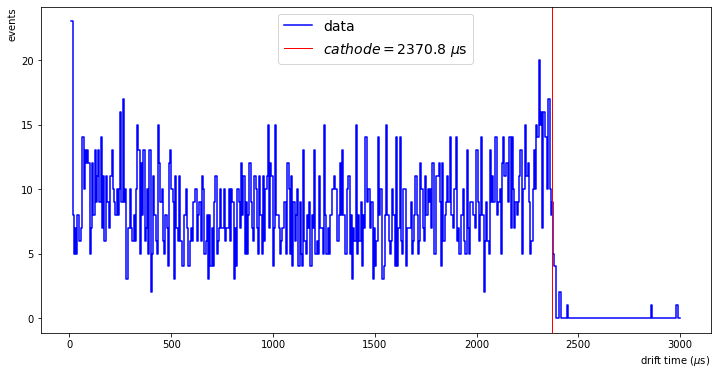

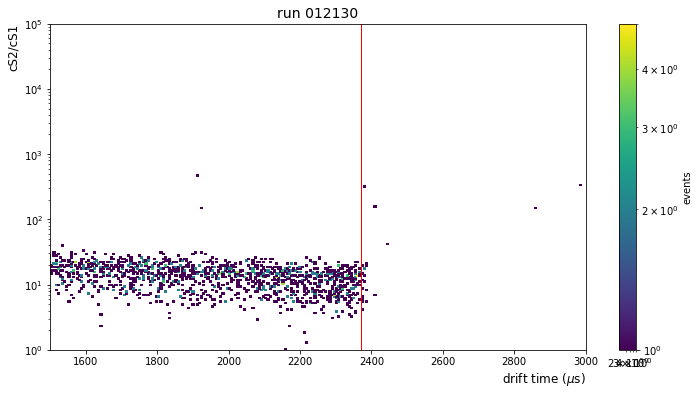

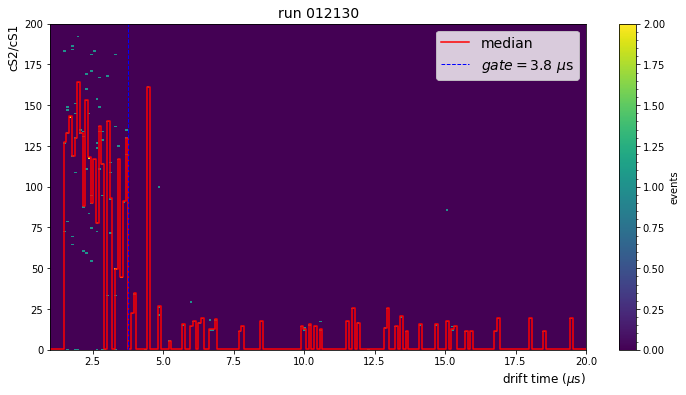

In [9]:
drift_time_calculation( run_kr = '012130', plot = True)

Drift velocity = 0.629~mm/$\mu$s


(12245,
 0.6287204182359399,
 0.002658606246290307,
 2364.849699398798,
 2.909547738693467)

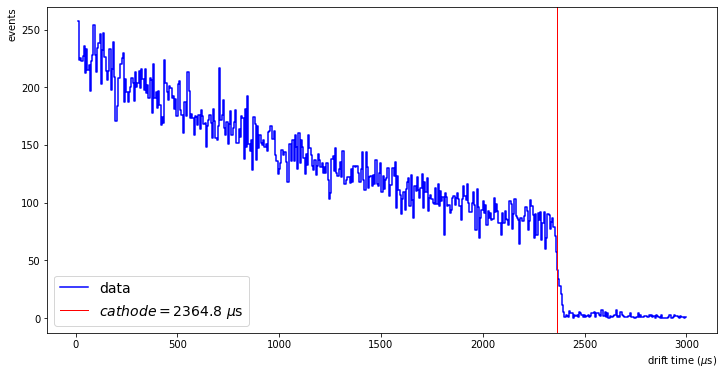

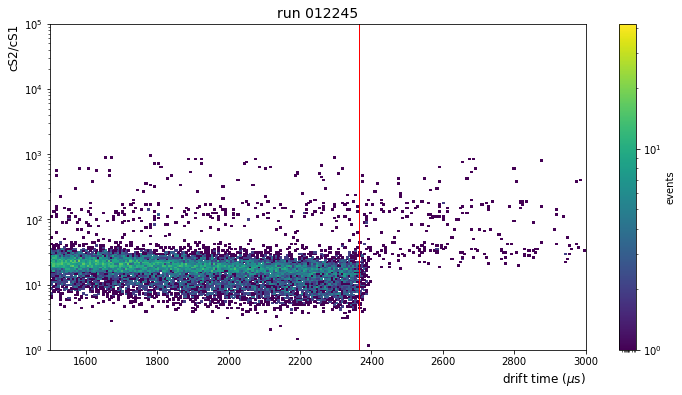

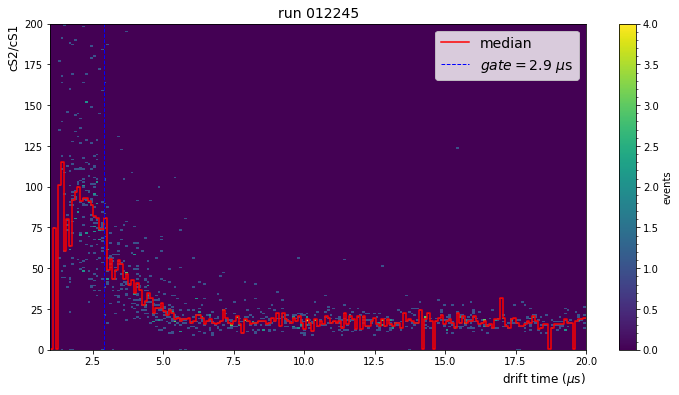

In [10]:
drift_time_calculation( run_kr = '012245', plot = True)

In [11]:
runs, vd, vd_err, cathode, gate = np.zeros(nn_1), np.zeros(nn_1), np.zeros(nn_1), np.zeros(nn_1), np.zeros(nn_1)
for i, run in enumerate(run_1):
    runs[i], vd[i], vd_err[i], cathode[i], gate[i] = drift_time_calculation(run)

In [12]:
runs2, vd2, vd2_err, cathode2, gate2 = np.zeros(nn_2), np.zeros(nn_2), np.zeros(nn_2), np.zeros(nn_2), np.zeros(nn_2)
for i, run in enumerate(run_2):
    runs2[i], vd2[i], vd2_err[i], cathode2[i], gate2[i] = drift_time_calculation(run)

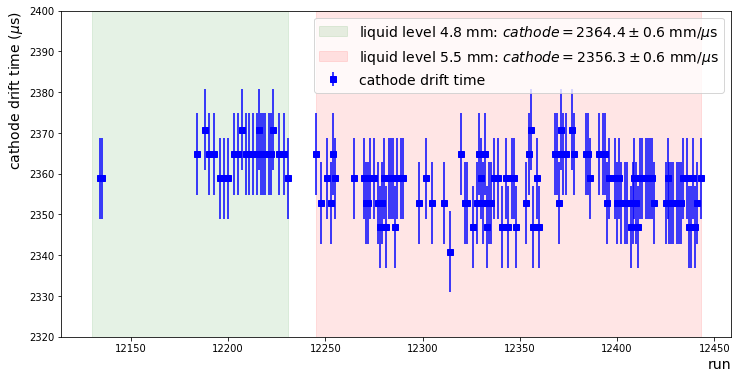

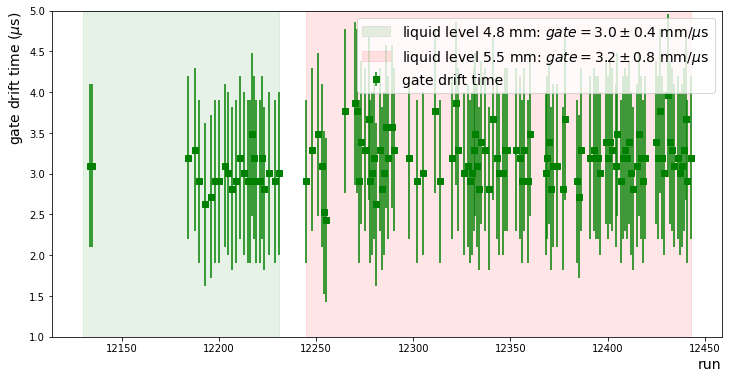

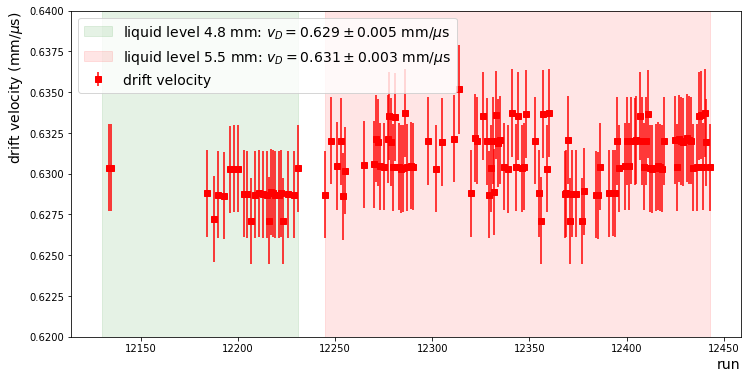

In [13]:
rr, vdd, vdd_err, cc, gg = np.concatenate((runs,runs2)), np.concatenate((vd,vd2)), np.concatenate((vd_err,vd2_err)), np.concatenate((cathode,cathode2)), np.concatenate((gate,gate2))
### cathode drop-off
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("cathode drift time ($\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr,cc,yerr=10,fmt='s',color='b',label='cathode drift time')
cm1, cm2 = cathode[cathode>0].mean(), cathode2[cathode2>0].mean()
cs1, cs2 = cathode[cathode>0].std()/np.sqrt(np.size(cathode)), cathode2[cathode2>0].std()/np.sqrt(np.size(cathode2))
plt.axvspan(12130,12231, alpha=0.1, color='g',
            label=f'liquid level 4.8 mm: $cathode = {cm1:.1f} \pm {cs1:.1f}$ mm/$\mu$s')
plt.axvspan(12245,12443, alpha=0.1, color='r',
            label=f'liquid level 5.5 mm: $cathode = {cm2:.1f} \pm {cs2:.1f}$ mm/$\mu$s')
plt.ylim(2320,2400)
plt.legend(fontsize=14)

### gate drift time
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("gate drift time ($\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr,gg,yerr=1,fmt='s',color='g',label='gate drift time')
gm1, gm2 = gate[gate>0].mean(), gate2[gate2>0].mean()
gs1, gs2 = (gate[gate>0].max()-gate[gate>0].min())/2, (gate2[gate2>0].max()-gate2[gate2>0].min())/2
plt.axvspan(12130,12231, alpha=0.1, color='g',
            label=f'liquid level 4.8 mm: $gate = {gm1:.1f} \pm {gs1:.1f}$ mm/$\mu$s')
plt.axvspan(12245,12443, alpha=0.1, color='r',
            label=f'liquid level 5.5 mm: $gate = {gm2:.1f} \pm {gs2:.1f}$ mm/$\mu$s')
plt.legend(fontsize=14)
plt.ylim(1,5)

# drif velocity
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("drift velocity (mm/$\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr,vdd,yerr=vdd_err,fmt='s',color='r',label='drift velocity')
m1, m2 = vd[vd>0].mean(), vd2[vd2>0].mean()
s1, s2 = vd[vd>0].std()/np.sqrt(np.size(vd))+vd_err[vd>0].mean()+vd_err[vd>0].mean(), vd2[vd2>0].std()/np.sqrt(np.size(vd2))+vd2_err[vd2>0].mean()
plt.axvspan(12130,12231, alpha=0.1, color='g',
            label=f'liquid level 4.8 mm: $v_D = {m1:.3f} \pm {s1:.3f}$ mm/$\mu$s')
plt.axvspan(12245,12443, alpha=0.1, color='r',
            label=f'liquid level 5.5 mm: $v_D = {m2:.3f} \pm {s2:.3f}$ mm/$\mu$s')
plt.ylim(0.62,0.64)
plt.legend(fontsize=14)